### 

In [1]:
import pandas as pd 
from utils import *
from training import *

fleet = ['VQ-BGU', 'VQ-BDU']
y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm']).query('oat > -100')
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm']).query('oat > -100')

### Visualize updated theta-correction procedure

In [33]:
def correct(data):
  datak = data.copy()
  alpha = 0.5
  alpha_2 = 0.84
  # mach = 1.0 + (data['mn'] ** 2) * 0.2 

  theta = (data['t2'] + 273.16) / (288.16)
  delta = data['p2e'] / 29.92

  datak['nfk'] = data['nf'] / (theta ** alpha)
  datak['n1ak'] = data['n1a'] / (theta ** alpha)
  datak['n1k'] = data['n1'] / (theta ** alpha)
  datak['n2ak'] = data['n2a'] / (theta ** alpha)
  datak['egtk'] = (data['egt'] + 273.16) / (theta ** 1)
  datak['egtk_2'] = (data['egt'] + 273.16) / theta
  datak['ffk'] = (data['ff']) / (delta * (theta ** 0.59))

  return datak

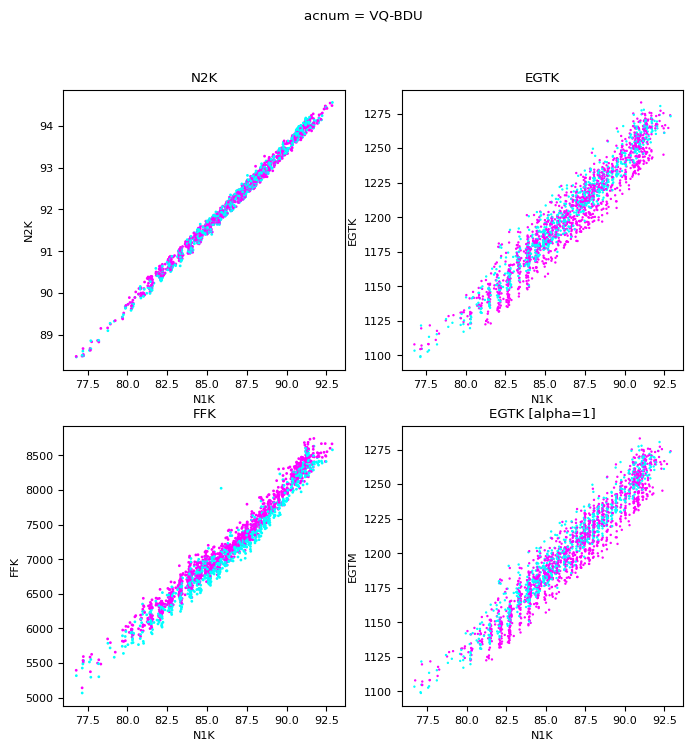

In [42]:
features = ['egt', 'tat', 'oat', 'n1a', 'n1p', 'n1c2', 'n1ak', 'n2a', 'n2p', 'n2ak', 'nf', 'egtk', 'egtk_2', 'ff', 'ffk', 'alt']

data = build_dataset(
  [correct(bdu)], 
  y_cols, 
  meta_cols, 
  features,
  n_back=0,
)

plt.rcParams.update({'font.size': 8})
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 8)
fig.suptitle('acnum = VQ-BDU')

axs[0, 0].scatter(data['n1ak'], data['n2ak'], s=1, c=data['pos'], cmap='cool')
axs[0, 0].set(xlabel='N1K', ylabel='N2K')
axs[0, 0].set_title('N2K')

axs[0, 1].scatter(data['n1ak'], data['egtk'], s=0.5, c=data['pos'], cmap='cool')
axs[0, 1].set(xlabel='N1K', ylabel='EGTK')
axs[0, 1].set_title('EGTK')

axs[1, 0].scatter(data['n1ak'], data['ffk'], s=1, c=data['pos'], cmap='cool')
axs[1, 0].set(xlabel='N1K', ylabel='FFK')
axs[1, 0].set_title('FFK')


axs[1, 1].scatter(data['n1c2'], data['egtk_2'], s=0.5, c=data['pos'], cmap='cool')
axs[1, 1].set(xlabel='N1K', ylabel='EGTM')
axs[1, 1].set_title('EGTK [alpha=1]')

plt.show()

Train an engine baseline:

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(data[['n1ak']], data['egtk'])

pred = model.predict(data[['n1ak']])

r2 = r2_score(data['egtk'],  pred)

f"R2 = {r2}"

'R2 = 0.9534182447018862'

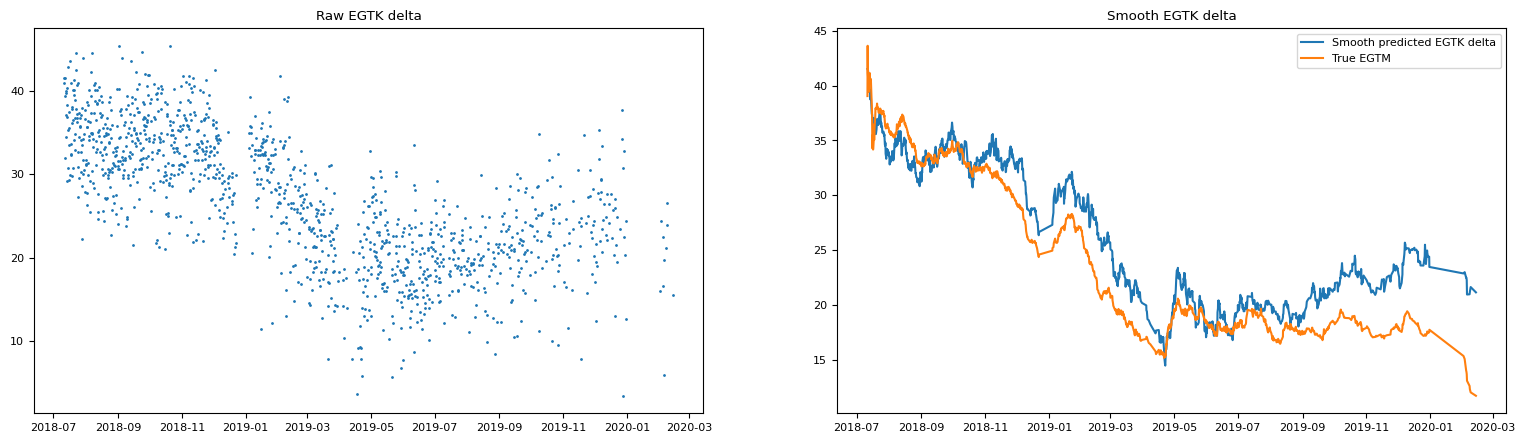

In [5]:
sub = data[data['pos'] == 2]
baseline = model.predict(sub[['n1ak']])
delta = baseline - sub['egtk'] + 26

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(19, 5)

axs[0].scatter(sub['reportts'],  delta, s=1)
axs[0].set_title('Raw EGTK delta')

axs[1].plot(sub['reportts'], smooth(delta, alpha=0.08))
axs[1].plot(sub['reportts'], sub['egtm'])
axs[1].set_title('Smooth EGTK delta')
axs[1].legend(['Smooth predicted EGTK delta', 'True EGTM'])

plt.show()

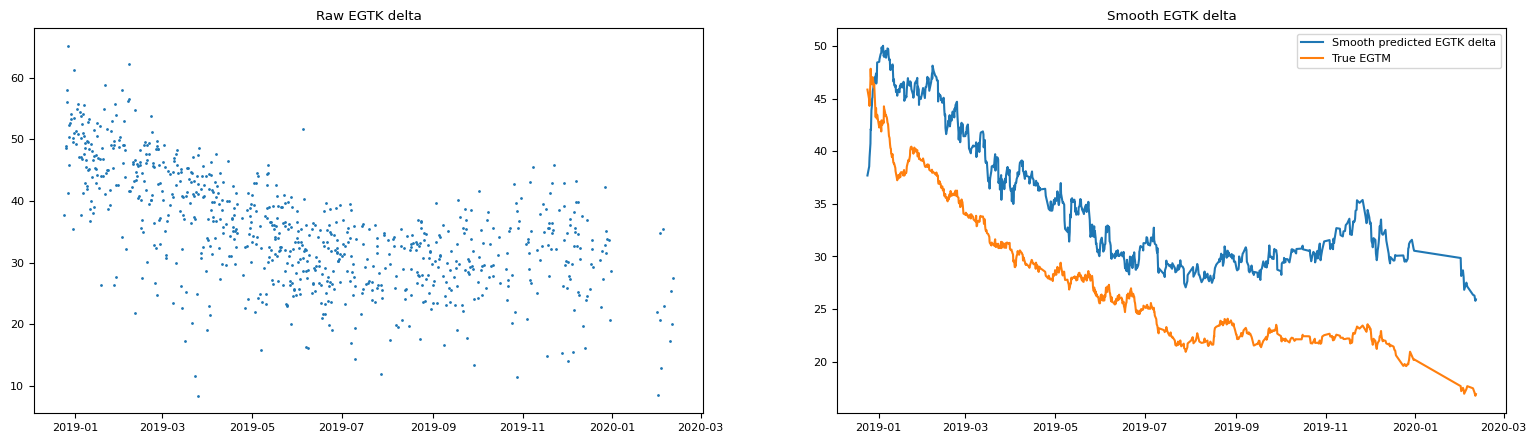

In [6]:
data_bgu = build_dataset(
  [correct(bgu)], 
  y_cols, 
  meta_cols, 
  features,
  n_back=0,
)

sub = data_bgu[data_bgu['pos'] == 2]
baseline = model.predict(sub[['n1ak']])
delta = baseline - sub['egtk'] + 26

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(19, 5)

axs[0].scatter(sub['reportts'],  delta, s=1)
axs[0].set_title('Raw EGTK delta')

axs[1].plot(sub['reportts'], smooth(delta, alpha=0.08))
axs[1].plot(sub['reportts'], sub['egtm'])
axs[1].set_title('Smooth EGTK delta')
axs[1].legend(['Smooth predicted EGTK delta', 'True EGTM'])

plt.show()

0. Попробовать использовать EGT_peak вместо EGT

1. Вывести Delta EGTK из train выборки (75%)
2. Предсказать Delta EGTK для всего датасета и добавить как признак
3. Сравнить качество с Экспериментом 5 

4. Разделить на неск. baseline по altitude (=3000) 
5. Рекурсия 
6. Bleed учесть (bool params) 

### Try to replace EGT with EGT_peak

Text(0.5, 1.0, 'EGT_peak corrected')

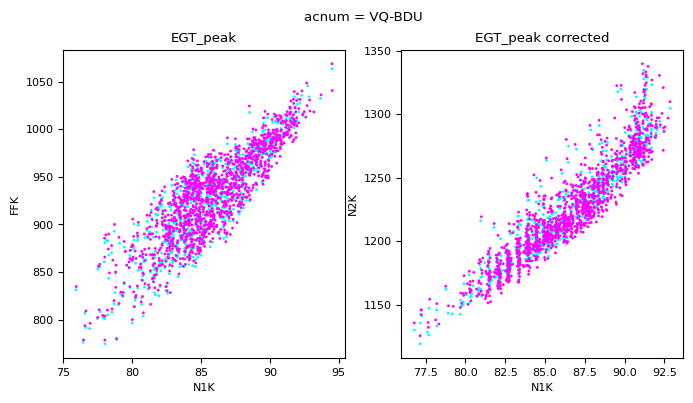

In [7]:
data = correct(bdu.query('egtb > 0').copy())

theta = (data['oat'] + 273.15) / 288.15
egt_peak = data['egt_peak']
egt_peak_k = (egt_peak + 273.15) / (theta ** 0.84)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
fig.suptitle('acnum = VQ-BDU')

axs[0].scatter(data['n1a'], egt_peak, s=1, c=data['pos'], cmap='cool')
axs[0].set(xlabel='N1K', ylabel='FFK')
axs[0].set_title('EGT_peak')

axs[1].scatter(data['n1ak'], egt_peak_k, s=1, c=data['pos'], cmap='cool')
axs[1].set(xlabel='N1K', ylabel='N2K')
axs[1].set_title('EGT_peak corrected')

Text(0.5, 1.0, 'EGT_peak corrected')

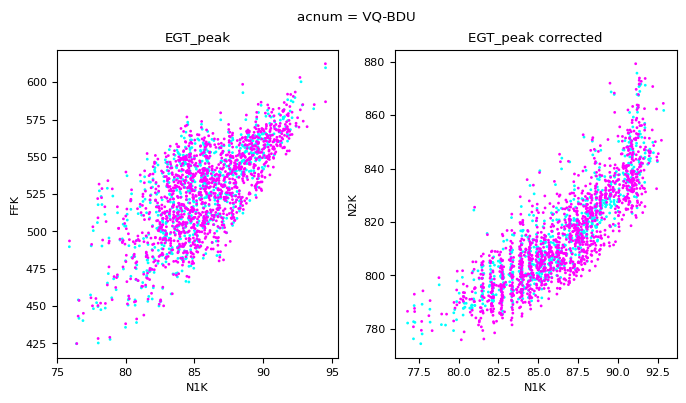

In [8]:
egtb = data['egtb']
egtbk = (egtb + 273.15) / (theta ** 0.84)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
fig.suptitle('acnum = VQ-BDU')

axs[0].scatter(data['n1a'], egtb, s=1, c=data['pos'], cmap='cool')
axs[0].set(xlabel='N1K', ylabel='FFK')
axs[0].set_title('EGT_peak')

axs[1].scatter(data['n1ak'], egtbk, s=1, c=data['pos'], cmap='cool')
axs[1].set(xlabel='N1K', ylabel='N2K')
axs[1].set_title('EGT_peak corrected')

In [9]:
data[['egt', 'egt_peak', 'egtb']].describe()

,egt,egt_peak,egtb
count,2074.000000,2074.000000,2074.000000
mean,907.279460,927.878881,526.442189
std,50.733459,47.394069,30.449912
min,713.200000,774.600000,424.700000
25%,875.000000,895.600000,505.900000
50%,908.150000,929.500000,529.400000
75%,942.600000,961.375000,549.500000
max,1046.700000,1068.700000,612.400000


### Baselines for each engine

In [10]:
data = build_dataset(
  [correct(bdu), correct(bgu)], 
  y_cols, 
  meta_cols, 
  features,
  n_back=0,
)

def train_engine_baseline(points: pd.DataFrame, x_param='n1ak', y_param='egtk'):
  model = LinearRegression()
  model.fit(points[[x_param]], points[y_param])
  return model

def compute_egtm(points: pd.DataFrame, model: LinearRegression, x_param='n1ak'):
  offset = 26
  delta = model.predict(points[[x_param]]) - points['egtk']
  return delta + offset

def train_model(X, y):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  models = {}

  predicted_test = pd.DataFrame(index=X_test.index.copy(), columns=['pred'])
  predicted_train = pd.DataFrame(index=X_train.index.copy(), columns=['pred'])

  for acnum in fleet: 
    for pos in [1, 2]:
      train_index = (X_train['pos'] == pos) & (X_train['acnum'] == acnum)
      test_index = (X_test['pos'] == pos) & (X_test['acnum'] == acnum)

      model = train_engine_baseline(X_train[train_index])
      
      models[f'{acnum}_{pos}'] = model
      
      predicted_test.loc[test_index, 'pred'] = compute_egtm(X_test[test_index], model)
      predicted_train.loc[train_index, 'pred'] = compute_egtm(X_train[train_index], model)
  
  return get_metrics(y_test, predicted_test), models, predicted_train, predicted_test, train_i, y_test

In [11]:
X = data.drop(columns=(y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

metrics

{'rmse': 6.16053, 'mae': 4.8527, 'r2': -5.73405, 'mape': 0.2362}

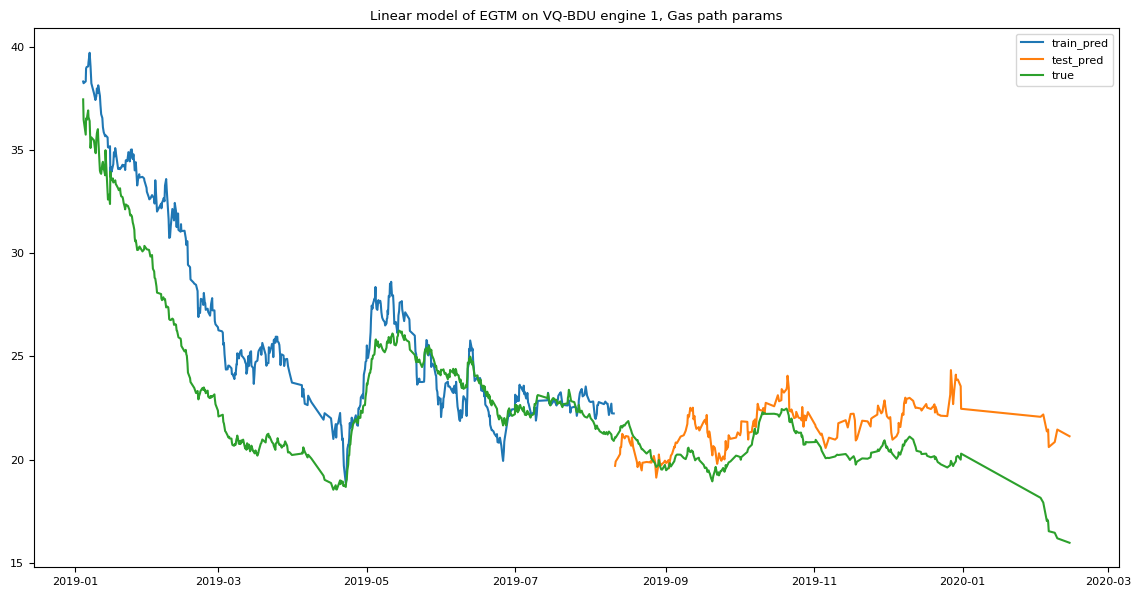

In [16]:
plot_predictions(data, 'VQ-BDU', 1, train_i, predicted_test['pred'], predicted_train['pred'], is_smooth=True, alpha=0.08)

In [ ]:
bgu[['prv', 'hpv', 'wai', 'nai']].describe()

,prv,hpv,wai,nai
count,1648.000000,1648.0,1648.0,1648.000000
mean,0.525485,0.0,0.0,0.098301
std,0.499502,0.0,0.0,0.297812
min,0.000000,0.0,0.0,0.000000
25%,0.000000,0.0,0.0,0.000000
50%,1.000000,0.0,0.0,0.000000
75%,1.000000,0.0,0.0,0.000000
max,1.000000,0.0,0.0,1.000000


Only prv and nai are present, try to filter them out and plot whats left